# 数据集准备和可视化

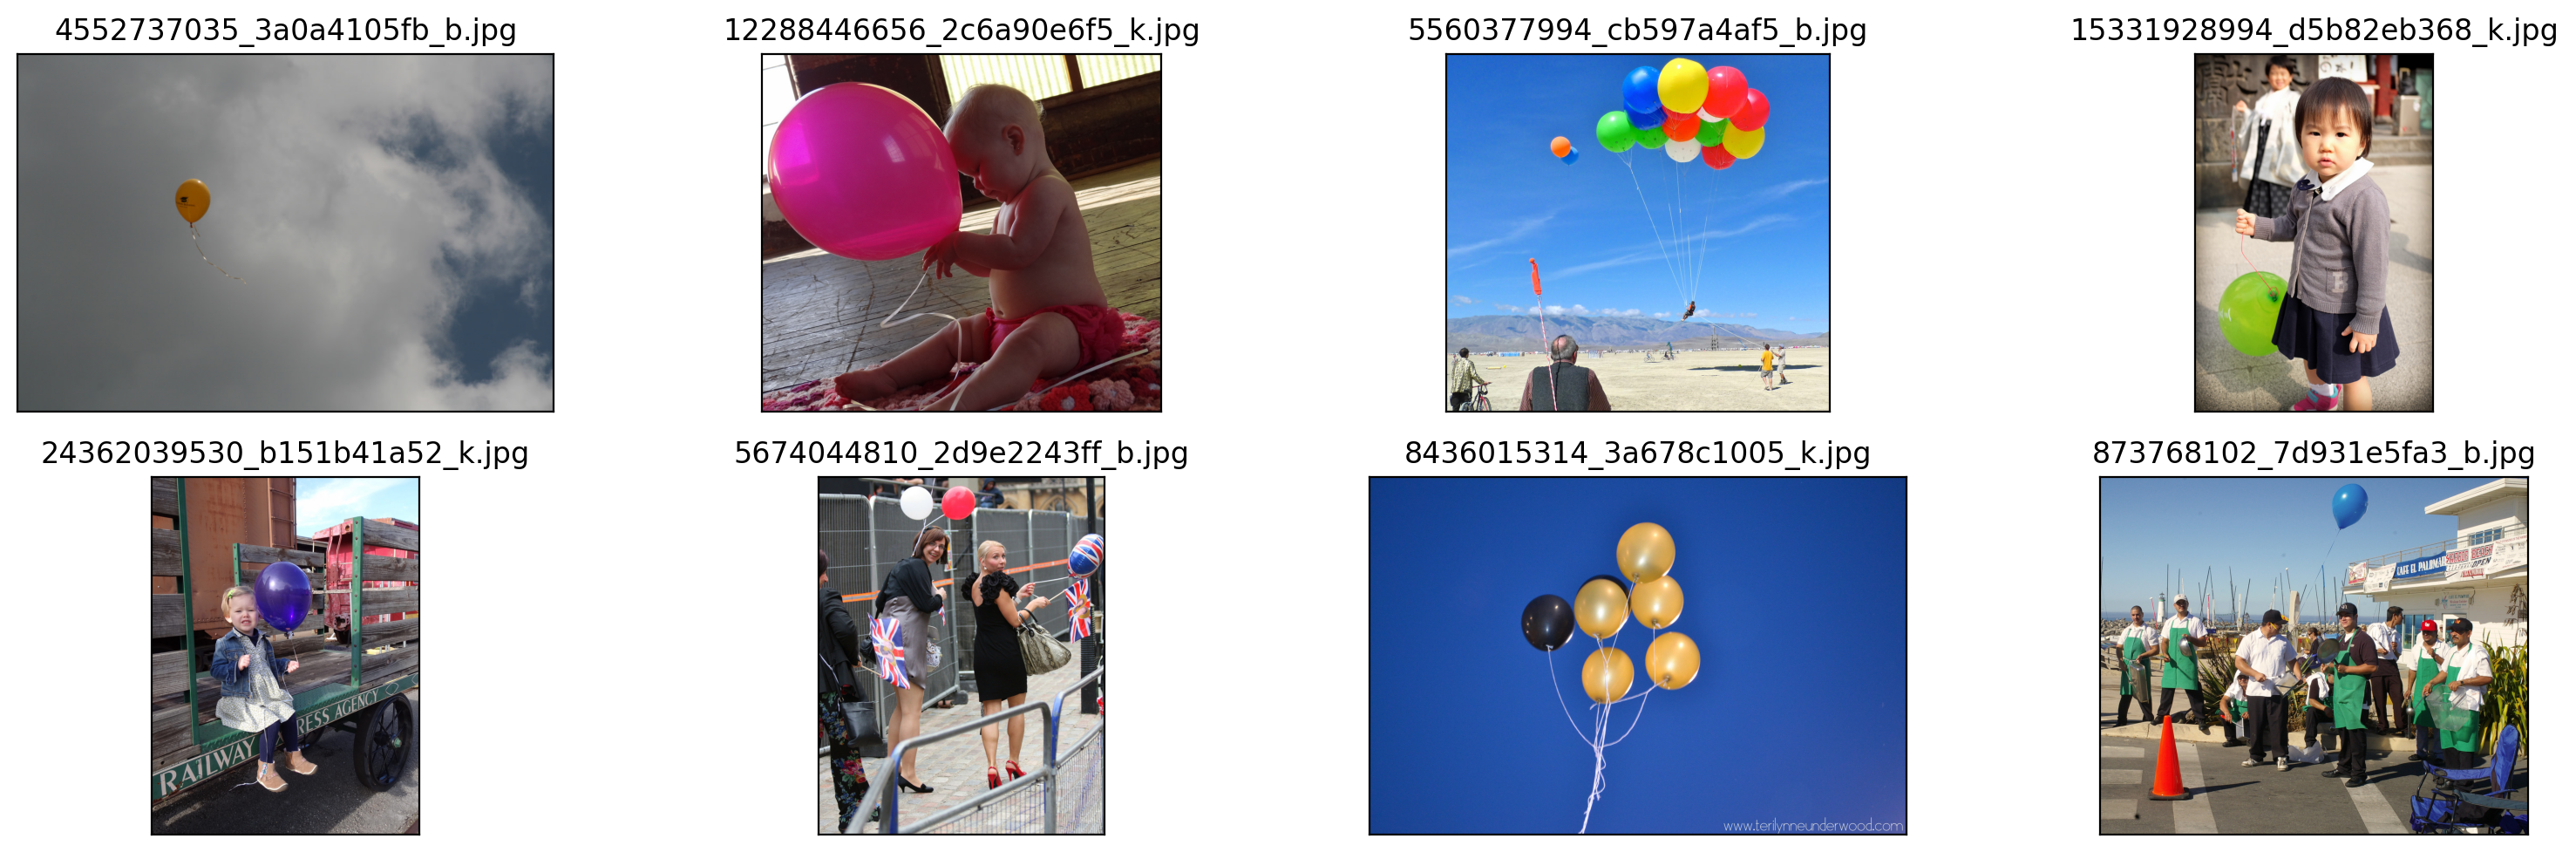

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

image_paths= [filename for filename in os.listdir('balloon/train')][:8]

for i,filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open('balloon/train/'+filename).convert("RGB")
  
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

将json转成coco格式

In [7]:
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress
import mmcv
import os.path as osp

def covert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)
    annotations, images = [], []
    obj_count = 0
    for idx, v in enumerate(track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)

        

In [8]:
covert_balloon_to_coco('balloon/train/via_region_data.json',
                       'balloon/train/annotation_coco.json',
                       'balloon/train/')
covert_balloon_to_coco('balloon/val/via_region_data.json',
                       'balloon/val/annotation_coco.json',
                       'balloon/val/')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 39.2 task/s, elapsed: 2s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 40.6 task/s, elapsed: 0s, ETA:     0s


COCO Json可视化

In [4]:
from pycocotools.coco import COCO
import numpy as np
import os.path as osp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

def apply_exif_orientation(image):
    _EXIF_ORIENT = 274
    if not hasattr(image, 'getexif'):
        return image

    try:
        exif = image.getexif()
    except Exception:
        exif = None

    if exif is None:
        return image

    orientation = exif.get(_EXIF_ORIENT)

    method = {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90,
    }.get(orientation)
    if method is not None:
        return image.transpose(method)
    return image


def show_bbox_only(coco, anns, show_label_bbox=True, is_filling=True):
    """Show bounding box of annotations Only."""
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat] = (np.random.random((1, 3)) * 0.7 + 0.3).tolist()[0]

    polygons = []
    colors = []

    for ann in anns:
        color = image2color[ann['category_id']]
        bbox_x, bbox_y, bbox_w, bbox_h = ann['bbox']
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y + bbox_h],
                [bbox_x + bbox_w, bbox_y + bbox_h], [bbox_x + bbox_w, bbox_y]]
        polygons.append(Polygon(np.array(poly).reshape((4, 2))))
        colors.append(color)

        if show_label_bbox:
            label_bbox = dict(facecolor=color)
        else:
            label_bbox = None

        ax.text(
            bbox_x,
            bbox_y,
            '%s' % (coco.loadCats(ann['category_id'])[0]['name']),
            color='white',
            bbox=label_bbox)

    if is_filling:
        p = PatchCollection(
            polygons, facecolor=colors, linewidths=0, alpha=0.4)
        ax.add_collection(p)
    p = PatchCollection(
        polygons, facecolor='none', edgecolors=colors, linewidths=2)
    ax.add_collection(p)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'id': 0, 'file_name': '24631331976_defa3bb61f_k.jpg', 'height': 2048, 'width': 1323}
{'id': 3, 'file_name': '8053085540_a72bd21a64_k.jpg', 'height': 1595, 'width': 2048}
{'id': 2, 'file_name': '14898532020_ba6199dd22_k.jpg', 'height': 1365, 'width': 2048}
{'id': 1, 'file_name': '16335852991_f55de7958d_k.jpg', 'height': 2048, 'width': 1536}
{'id': 10, 'file_name': '3800636873_ace2c2795f_b.jpg', 'height': 1024, 'width': 686}
{'id': 11, 'file_name': '2917282960_06beee649a_b.jpg', 'height': 681, 'width': 1024}
{'id': 4, 'file_name': '6810773040_3d81036d05_k.jpg', 'height': 1536, 'width': 2048}
{'id': 7, 'file_name': '4838031651_3e7b5ea5c7_b.jpg', 'height': 675, 'width': 1024}


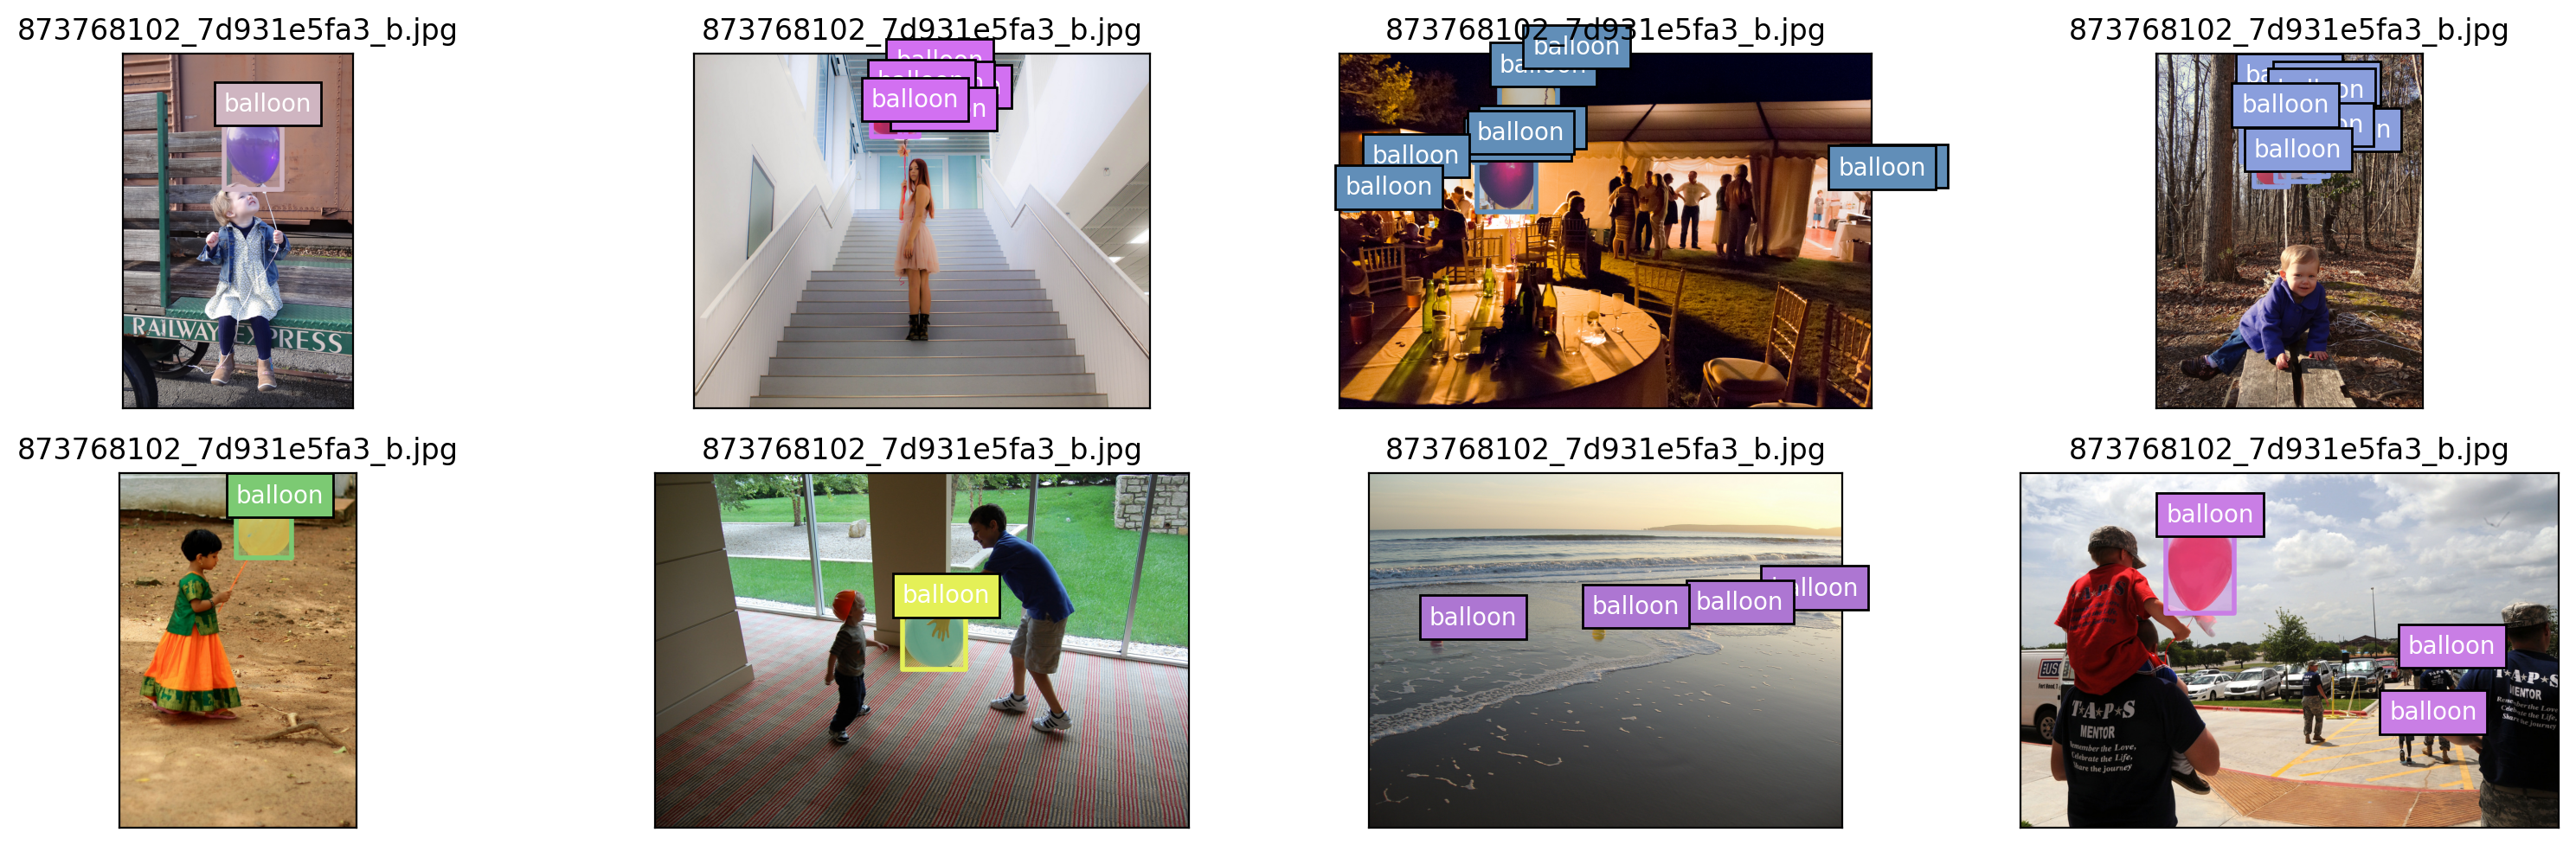

In [10]:
coco = COCO('balloon/val/annotation_coco.json')
image_ids = coco.getImgIds()
np.random.shuffle(image_ids)

plt.figure(figsize=(16, 5))

# 只可视化 8 张图片
for i in range(8):
    image_data = coco.loadImgs(image_ids[i])[0]
    print(image_data)
    image_path = osp.join('balloon/val/',image_data['file_name'])

    annotation_ids = coco.getAnnIds(
            imgIds=image_data['id'], catIds=[], iscrowd=0)
    
    annotations = coco.loadAnns(annotation_ids)
    
    ax = plt.subplot(2, 4, i+1)
    image = Image.open(image_path).convert("RGB")
    
    # 这行代码很关键，否则可能图片和标签对不上
    image=apply_exif_orientation(image)
    
    ax.imshow(image)
    
    show_bbox_only(coco, annotations)
    
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])
        
plt.tight_layout()    

# 训练微调的气球数据集

In [24]:
!mim train mmdet configs/rtmdet/rtmdet_tiny_8xb32_80e_balloon.py --work-dir=./log/train

Training command is /home/leo/miniconda3/envs/openmmlab/bin/python /home/leo/Code/mmdetection/mmdet/.mim/tools/train.py configs/rtmdet/rtmdet_tiny_8xb32_80e_balloon.py --launcher none --work-dir=./log/train. 
06/12 12:54:56 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 863571552
    GPU 0: NVIDIA GeForce GTX 1660 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LA

# 模型测试和推理

In [28]:
!mim test mmdet configs/rtmdet/rtmdet_tiny_8xb32_80e_balloon.py -C /home/leo/Code/openmmlab_work/03_balloon_detection/log/train/epoch_80.pth --work-dir /home/leo/Code/openmmlab_work/03_balloon_detection/test_balloon

Testing command is /home/leo/miniconda3/envs/openmmlab/bin/python /home/leo/Code/mmdetection/mmdet/.mim/tools/test.py configs/rtmdet/rtmdet_tiny_8xb32_80e_balloon.py /home/leo/Code/openmmlab_work/03_balloon_detection/log/train/epoch_80.pth --launcher none --work-dir /home/leo/Code/openmmlab_work/03_balloon_detection/test_balloon. 
06/12 13:16:47 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 507179894
    GPU 0: NVIDIA GeForce GTX 1660 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
